In [10]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
from statsmodels.stats.anova import AnovaRM
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import find_peaks, peak_prominences, peak_widths
from scipy.integrate import trapezoid
from statsmodels.formula.api import ols
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import iqr
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

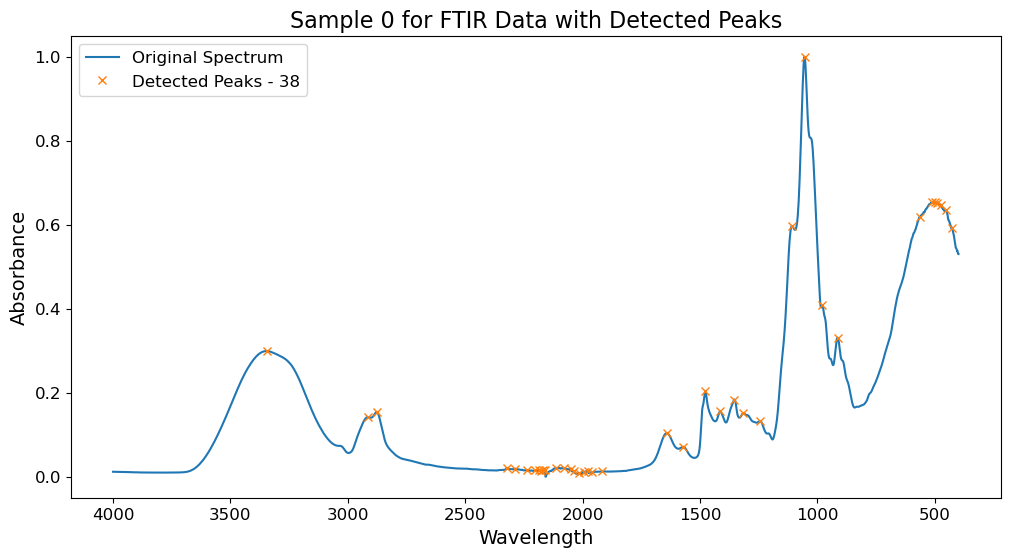

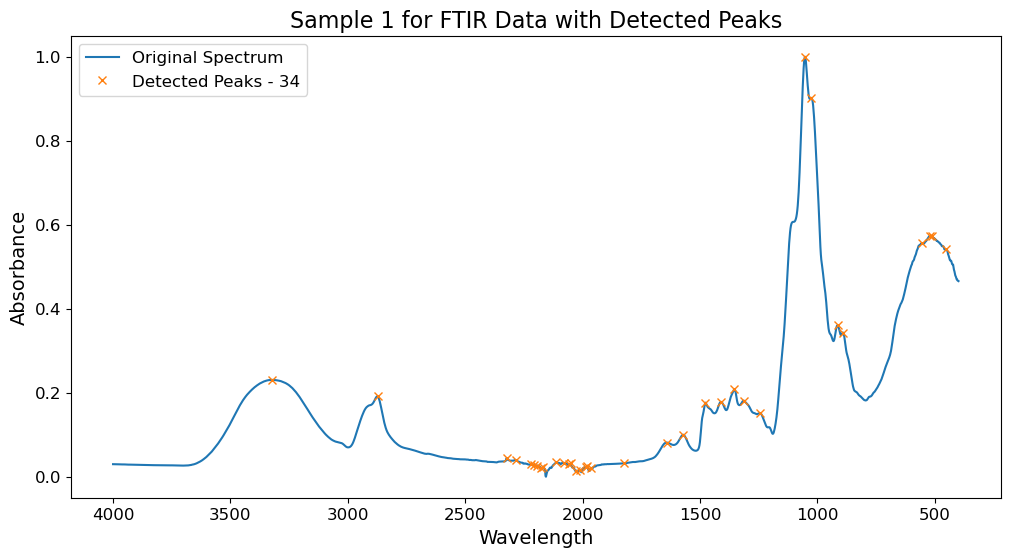

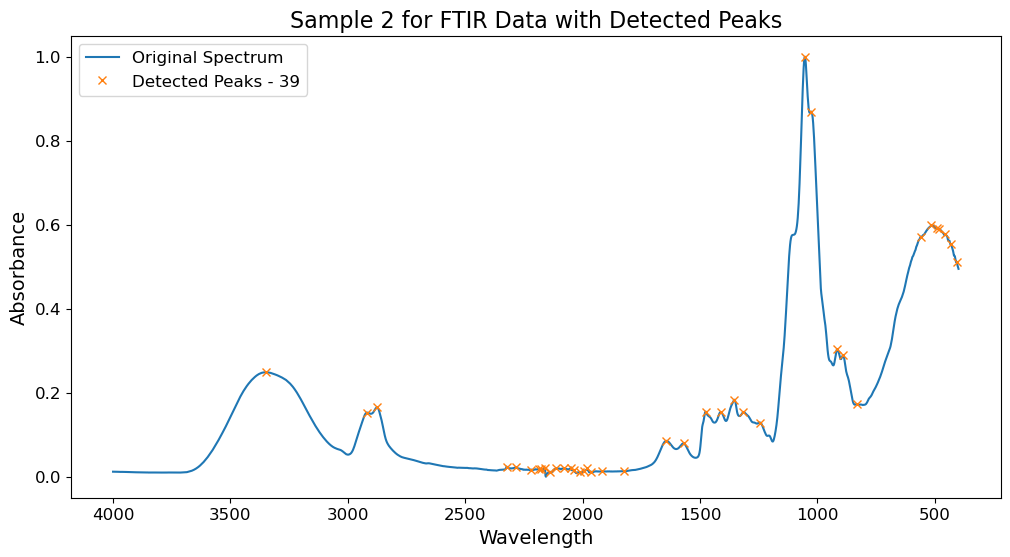

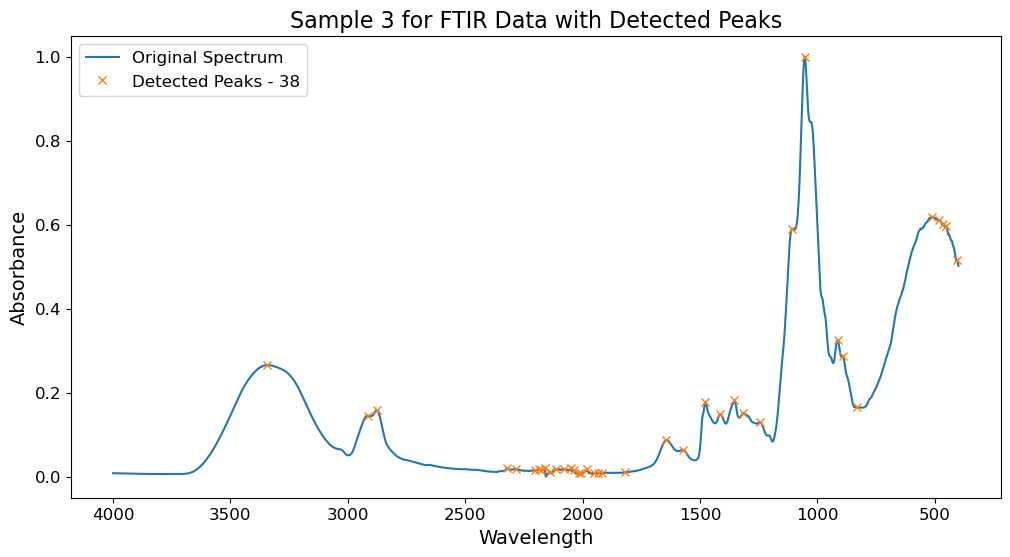

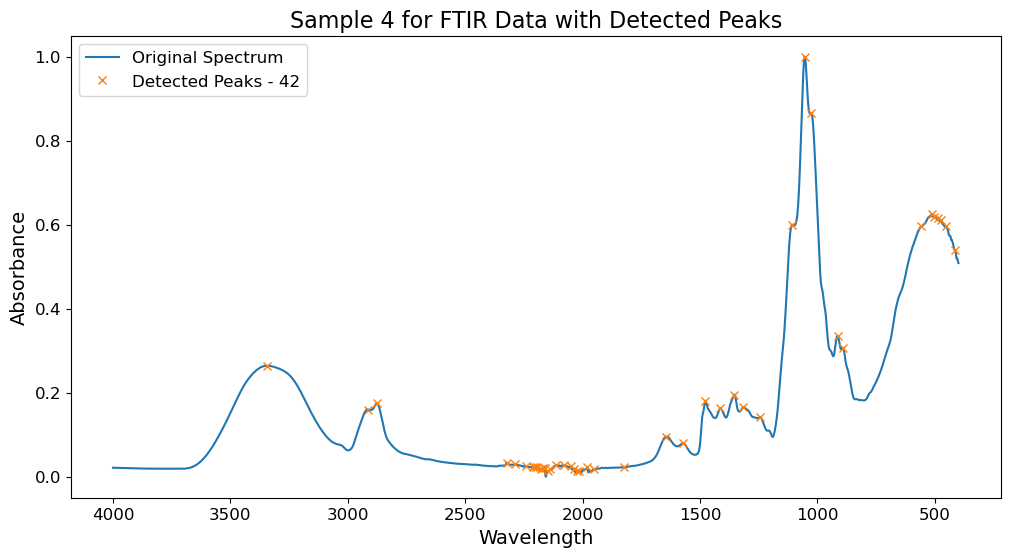

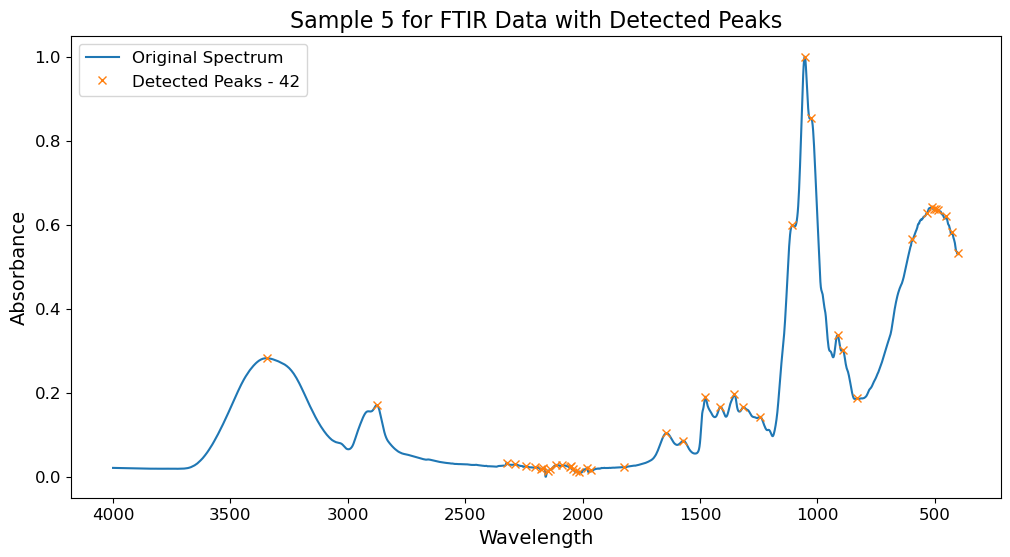

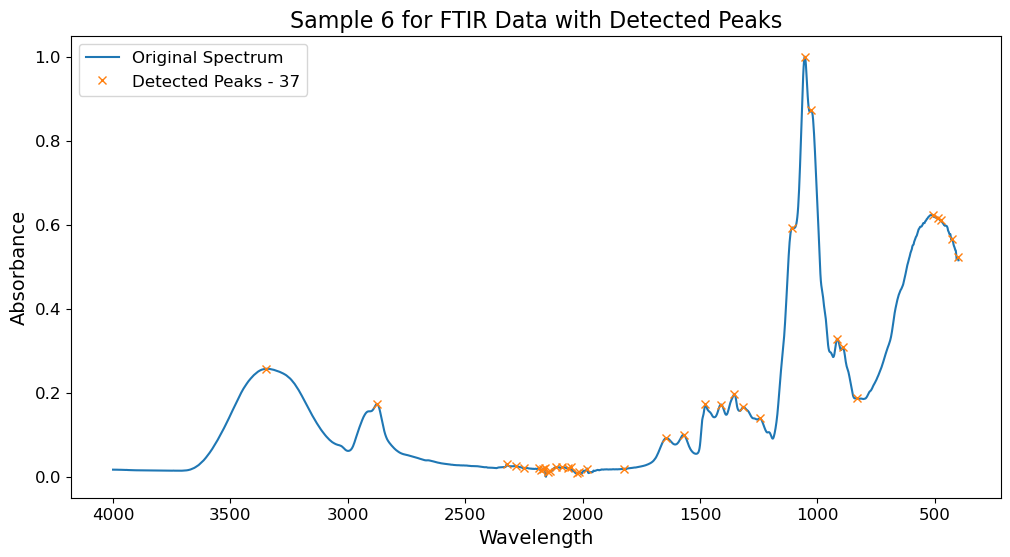

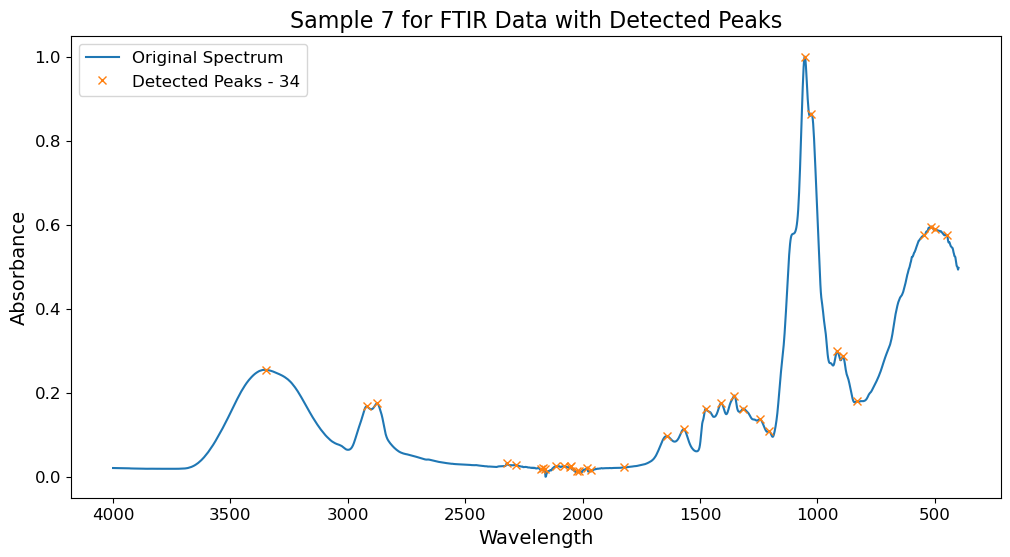

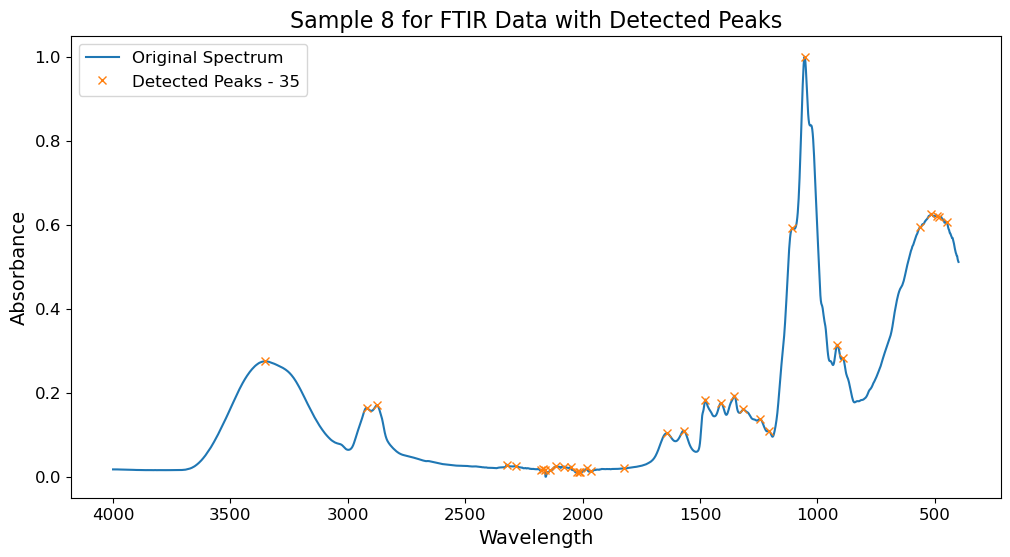

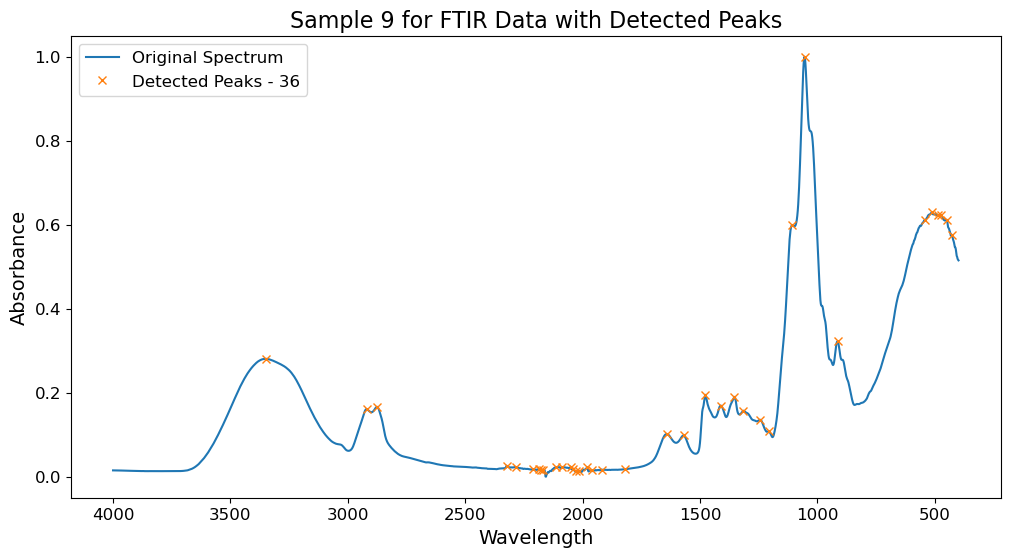

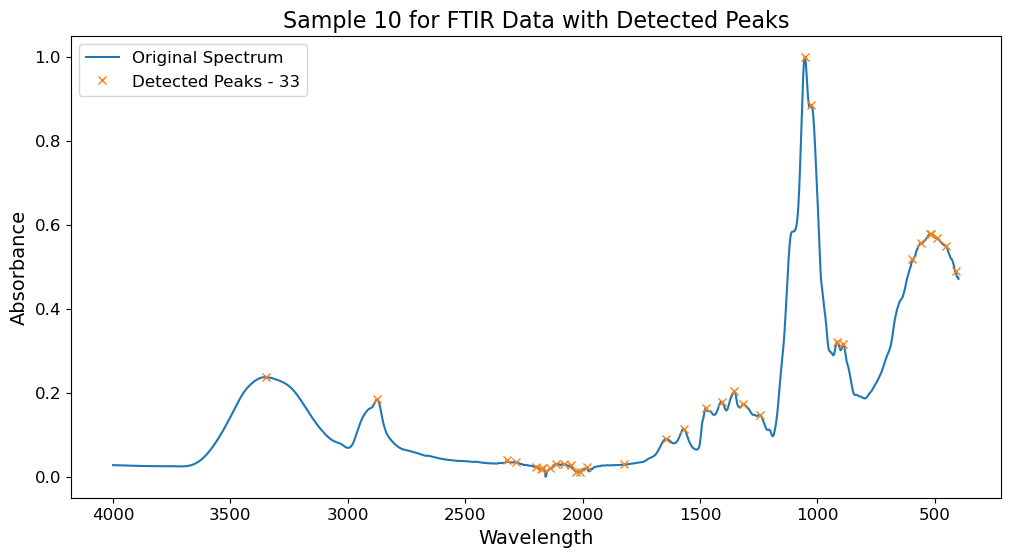

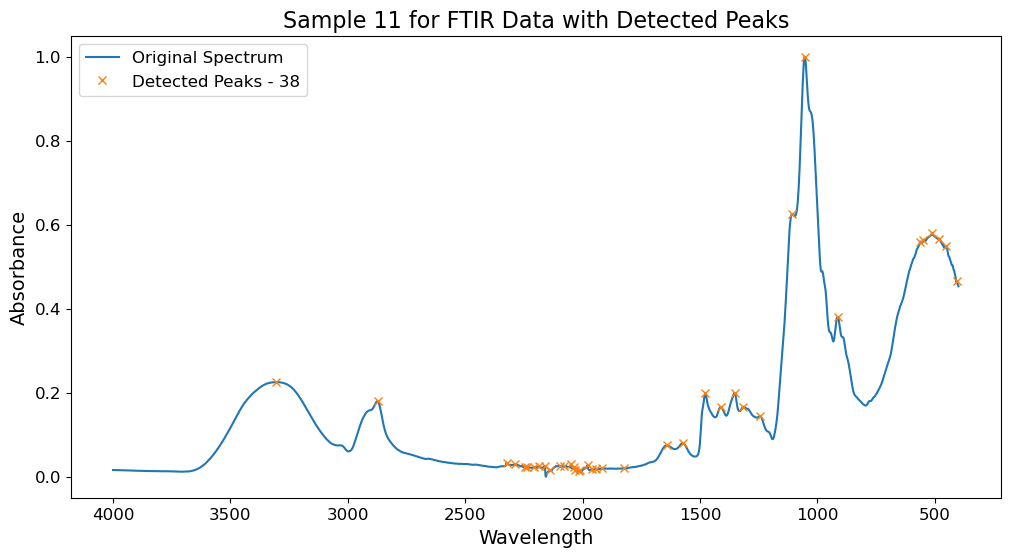

In [11]:
def load_and_normalize_data(filepath):
    ftir_df = pd.read_csv(filepath)
    index_labels = ftir_df.index
    ftir_abs = ftir_df.filter(regex='Absorbance_')
    ftir_wavelength = ftir_df.filter(regex='Wavenumber\[1/cm\]_')

    sorted_indices = ftir_wavelength.iloc[0].argsort()[::-1]
    ftir_wavelength = ftir_wavelength.iloc[:, sorted_indices]
    ftir_abs = ftir_abs.iloc[:, sorted_indices]

    # Subtract min and divide by max-min for each row to normalize
    ftir_abs_normalized = (ftir_abs.subtract(ftir_abs.min(axis=1), axis=0)
                                .div(ftir_abs.max(axis=1) - ftir_abs.min(axis=1), axis=0))
    return ftir_wavelength, ftir_abs_normalized, index_labels

filepath = "/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/FTIR Data/FTIR_data.csv"
ftir_wavelength, normalized_absorbance, index_labels = load_and_normalize_data(filepath)

# print(ftir_wavelength)
# print(normalized_absorbance)


peaks_info = []

for sample_index in range(normalized_absorbance.shape[0]):
    spectrum = normalized_absorbance.iloc[sample_index, :].copy()
    org_spectrum = spectrum.copy()
    wavelength_values = ftir_wavelength.iloc[sample_index, :]
    peaks, _ = find_peaks(spectrum, prominence=0.0009)
    peak_count = len(peaks)
    peaks_info.append(peaks)


    plt.figure(figsize=(12, 6))
    plt.plot(ftir_wavelength.iloc[sample_index, :], org_spectrum, label='Original Spectrum')
    plt.plot(ftir_wavelength.iloc[sample_index, peaks], spectrum.iloc[peaks], "x", label=f'Detected Peaks - {peak_count}')
    #plt.xlim(800, 900)
    plt.title(f'Sample {sample_index} for FTIR Data with Detected Peaks', fontsize=16)
    plt.xlabel('Wavelength', fontsize=14)
    plt.ylabel('Absorbance', fontsize=14)
    plt.xticks(fontsize=12)  
    plt.yticks(fontsize=12)  
    plt.legend(fontsize=12)
    plt.gca().invert_xaxis()
    plt.show()


Binning by picking the sample that has the greatest number of peaks

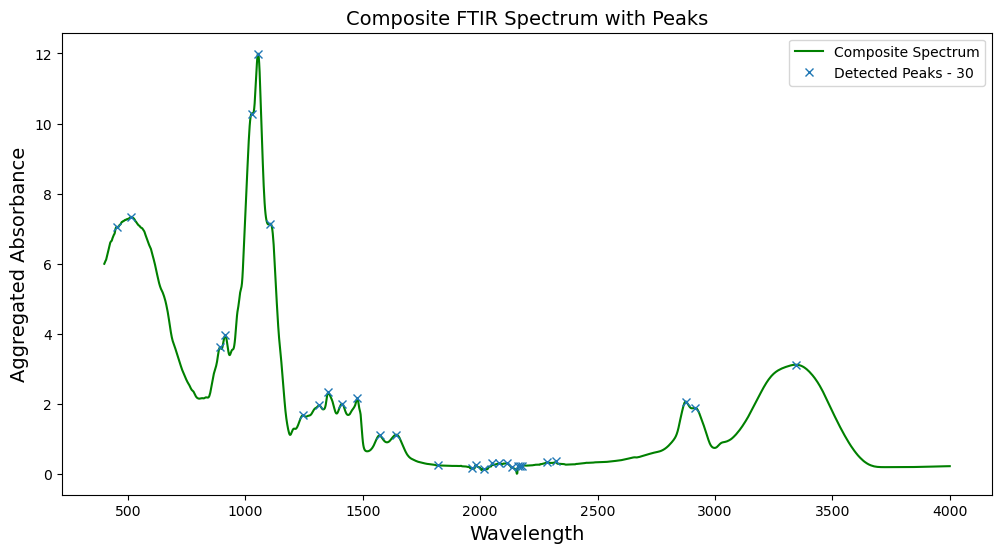

         Bin_0     Bin_1      Bin_2     Bin_3     Bin_4     Bin_5     Bin_6  \
0  -158.166364 -4.844679 -31.093495 -3.643638 -0.824444 -0.051609 -0.264382   
1  -166.690433 -5.755152 -40.552410 -7.906159 -1.736443 -0.079921 -0.417330   
2  -143.091549 -5.198946 -32.233688 -3.945159 -0.935522 -0.067571 -0.362658   
3  -142.880728 -4.959844 -30.655497 -3.269323 -0.799604 -0.058294 -0.345319   
4  -163.565136 -5.460443 -36.068026 -5.878863 -1.310647 -0.066881 -0.373805   
5  -169.872814 -5.321981 -35.829979 -5.798441 -1.297185 -0.070196 -0.379680   
6  -155.659282 -5.302361 -35.281541 -5.055919 -1.136364 -0.062513 -0.352550   
7  -160.436020 -5.656560 -36.528861 -5.589570 -1.243221 -0.065670 -0.341564   
8  -163.033117 -5.540494 -35.571502 -4.960603 -1.113030 -0.056614 -0.311044   
9  -160.839451 -5.433926 -34.431137 -4.472743 -1.013090 -0.058343 -0.296209   
10 -164.588721 -5.448435 -38.639554 -7.110188 -1.546629 -0.068878 -0.352910   
11 -145.927487 -5.336148 -36.241726 -5.646739 -1.293

In [12]:
def aggregate_intensities(normalized_absorbance):

    return normalized_absorbance.sum(axis=0)

def bin_around_peaks(normalized_absorbance, ftir_wavelength, widths):

    binned_data_list = []

    for i in range(normalized_absorbance.shape[0]):
        sample_abs = normalized_absorbance.iloc[i, :].values
        wavelength_values = ftir_wavelength.iloc[i, :].values
        binned_sample_data = []

        for j, peak in enumerate(no_water_peaks):

            window_width = int(widths[0][j])
            window_start = max(0, peak - window_width)
            window_end = min(len(sample_abs), peak + window_width + 1)
            bin_area = np.trapz(sample_abs[window_start:window_end], wavelength_values[window_start:window_end])
            binned_sample_data.append(bin_area)

        binned_data_list.append(binned_sample_data)

    return pd.DataFrame(binned_data_list, columns=[f'Bin_{i}' for i in range(len(no_water_peaks))])


composite_spectrum = aggregate_intensities(normalized_absorbance)


no_water_peaks, properties = find_peaks(composite_spectrum, prominence=0.01)  # adjust prominence as needed
widths = peak_widths(composite_spectrum, no_water_peaks, rel_height=0.995)

# Perform binning based on the peak widths
binned_data_df = bin_around_peaks(normalized_absorbance, ftir_wavelength, widths)

plt.figure(figsize=(12, 6))
plt.plot(ftir_wavelength.iloc[1, :], composite_spectrum, color='Green', label='Composite Spectrum')
plt.plot(ftir_wavelength.iloc[1, no_water_peaks], composite_spectrum[no_water_peaks], "x", label=f'Detected Peaks - {len(no_water_peaks)}')
plt.legend()
plt.title('Composite FTIR Spectrum with Peaks', fontsize=14)
plt.xlabel('Wavelength', fontsize=14)
plt.ylabel('Aggregated Absorbance', fontsize=14)
plt.show()


print(binned_data_df)
print("Left IPS:", widths[2])
print("Right IPS:", widths[3])

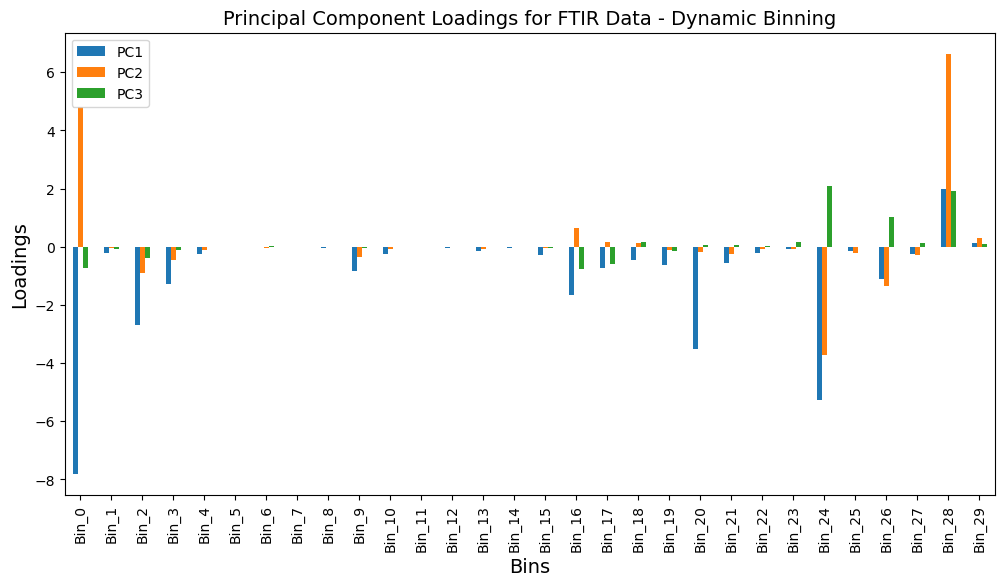

[0.54878441 0.38686177 0.04926323]


In [13]:
pca = PCA(n_components=3)

principal_components = pca.fit_transform(binned_data_df)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=binned_data_df.columns)

fig, ax = plt.subplots(figsize=(12,6))
loading_matrix.plot(kind='bar', ax=ax)
plt.title('Principal Component Loadings for FTIR Data - Dynamic Binning', fontsize=14)
plt.ylabel('Loadings', fontsize=14)
plt.xlabel('Bins', fontsize=14)
plt.show()

# print(principal_df)
# print(loading_matrix)
print(pca.explained_variance_ratio_)

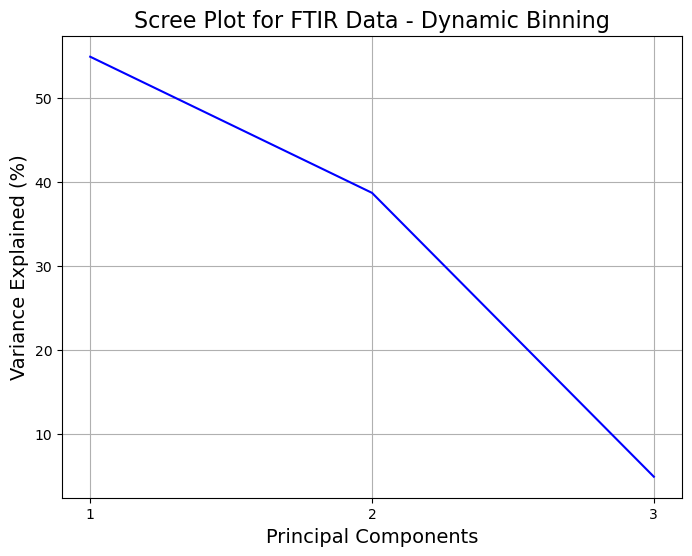

In [14]:
explained_variance = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(range(1, len(explained_variance)+1), explained_variance*100, color='blue')
plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Variance Explained (%)', fontsize=14)
plt.title('Scree Plot for FTIR Data - Dynamic Binning', fontsize=16)
plt.xticks(range(1, len(explained_variance)+1)) 
plt.grid(True)
plt.show()

In [15]:
principal_df.to_csv("/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/FTIR Data/PC_FTIR.csv")

Linear and OLS Regression

In [16]:
performance_data = pd.read_csv("/Users/suhasmathey/Library/CloudStorage/OneDrive-UniversityofDelaware-o365/Spring_24/ELEG848 Soft Materials Inn/NMR_Data/tidy_performance_2.0.csv", index_col='Sample')
Y = performance_data['Performance (mean)']

Y.reset_index(drop=True, inplace=True)


poly = PolynomialFeatures(degree=1)
X_poly = poly.fit_transform(principal_df)

#print(X_poly)
print(principal_df)

lin_reg_poly = LinearRegression()
lin_reg_poly.fit(X_poly, Y)
Y_pred_poly = lin_reg_poly.predict(X_poly)

Mean_abs_error = mean_absolute_error(Y, Y_pred_poly)
Mean_sqr_error = mean_squared_error(Y, Y_pred_poly)

print("Mean Absolute Error for FTIR Data:", Mean_abs_error)
print("Mean Sqaure Error for FTIR Data:", Mean_sqr_error)

r_sqaure_poly = r2_score(Y, Y_pred_poly)



X_poly_sm = sm.add_constant(X_poly)
ols_model_poly = sm.OLS(Y, X_poly_sm).fit()
ols_summary_poly = ols_model_poly.summary()

print("R-Sqaured for Polynomial Regression:", r_sqaure_poly)
print("OLS Summary:", ols_summary_poly)

          PC1        PC2       PC3
0   -8.654107 -11.966190 -1.386300
1   19.148766  10.052830 -0.724898
2  -16.817466   7.212853  2.279408
3  -18.706295   3.808786 -0.864987
4    5.271016  -3.661955 -2.344144
5    9.114984 -11.178942 -3.490389
6   -0.890964  -0.476111 -4.118030
7    1.316713  -0.740887  6.307767
8    1.904046  -8.075864  1.852654
9   -1.300315  -7.933994  1.491955
10  11.267836   4.742566  4.356497
11  -1.654215  18.216908 -3.359532
Mean Absolute Error for FTIR Data: 2.5405439070998046
Mean Sqaure Error for FTIR Data: 8.991719975543909
R-Sqaured for Polynomial Regression: 0.0685908985452589
OLS Summary:                             OLS Regression Results                            
Dep. Variable:     Performance (mean)   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                 -0.281
Method:                 Least Squares   F-statistic:                    0.1964
Date:                Sat, 03 Aug 2024   Prob (F-statist

/Users/suhasmathey/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  k, _ = kurtosistest(a, axis)


Decision Tree Regressor

In [17]:
print(Y_pred_poly)

[16.67067699 15.76411513 15.4175033  15.2654499  16.27589249 16.81717234
 15.66884804 16.95639664 17.0166034  16.88242464 16.56171474 14.30320239]


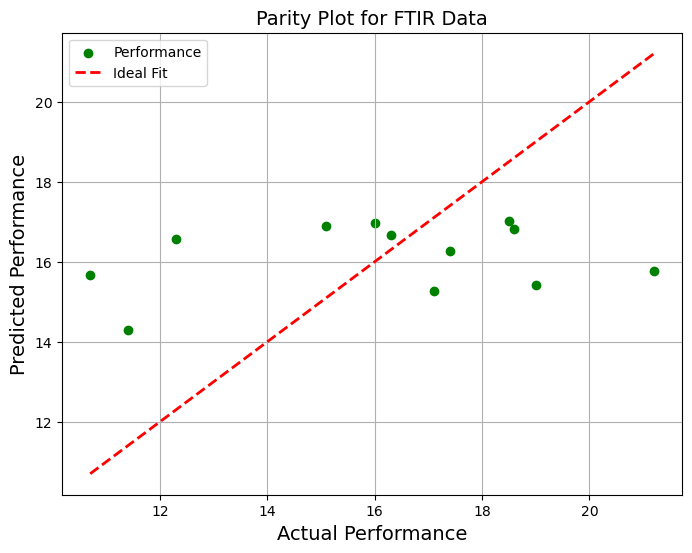

In [18]:

plt.figure(figsize=(8, 6))
plt.scatter(Y, Y_pred_poly, color= 'Green', label='Performance')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--', lw=2, label='Ideal Fit')

plt.xlabel('Actual Performance', fontsize=14)
plt.ylabel('Predicted Performance', fontsize=14)
plt.title('Parity Plot for FTIR Data', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()